In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import datetime as dt


parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from gaussian_process import *

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year
df['is_holiday'] = (~ df['holiday'].isnull()).astype(int)
df['time_step'] = (df['date_time'] - pd.Timestamp("2012-10-02 09:00:00")) // pd.Timedelta(hours=1) # hours since 2012-10-20 9am

# Training data
df_train = df[df['date_time'].dt.year.isin([2016, 2017])] # 2016, 2016 as training data
df_test = df[df['date_time'].dt.year.isin([2018])] # 2018 for validation

# only include time data
X_train = df_train[['time_step']]
X_test = df_test[['time_step']]

y_train = df_train['traffic_volume']
y_test = df_test['traffic_volume']

In [ ]:
alpha = np.load('../results/alpha_periodic_1w_l0.01_s1.npy')
mu_train = np.load('../results/mean_train_1w_l0.01_s1.npy')
mu_test = np.load('../results/mean_test_1w_l0.01_s1.npy')
cov_test = np.load('../results/cov_test_1w_l0.01_s1.npy')

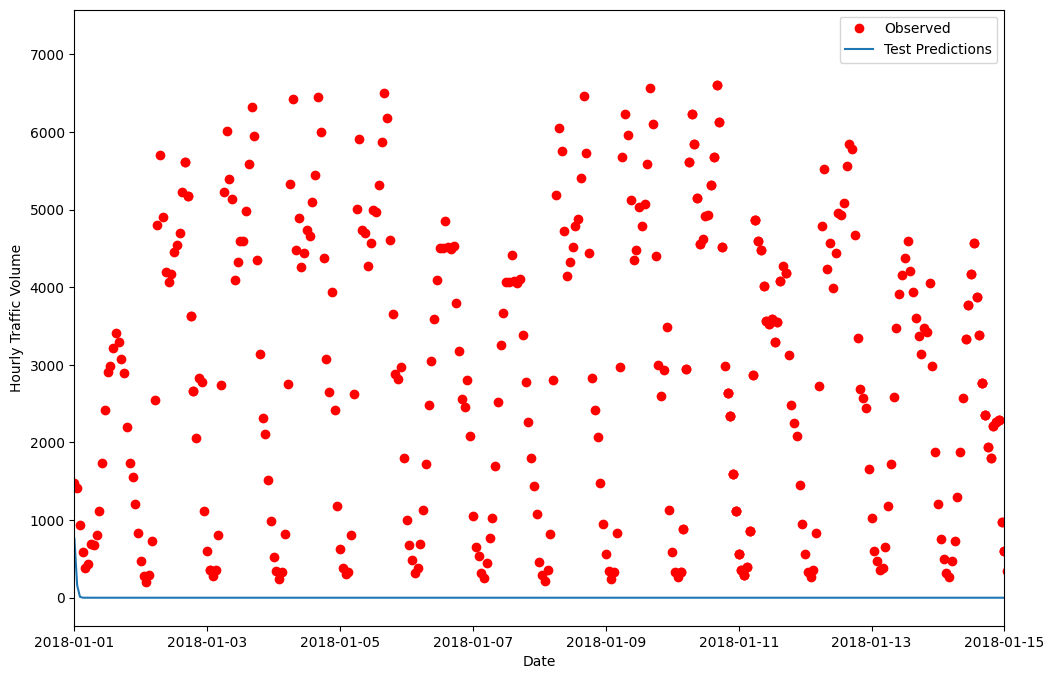

In [43]:
plt.figure(figsize = (12, 8))
#plt.plot(df_train['date_time'], mu_train)
plt.plot(df_test['date_time'], df_test['traffic_volume'], 'ro', label = 'Observed')
plt.plot(df_test['date_time'], mu_test, label = 'Test Predictions')
plt.xlim(dt.datetime(2018, 1, 1, 0), dt.datetime(2018, 1, 15, 0))
plt.xlabel('Date')
plt.ylabel('Hourly Traffic Volume')
plt.legend()
plt.show()

In [41]:
alpha = np.load('../results/alpha_rbf_l1_s1.npy')
mu_train = np.load('../results/mean_train_rbf_l1_s1.npy')
mu_test = np.load('../results/mean_test_rbf_l1_s1.npy')
cov_test = np.load('../results/cov_test_rbf_l1_s1.npy')

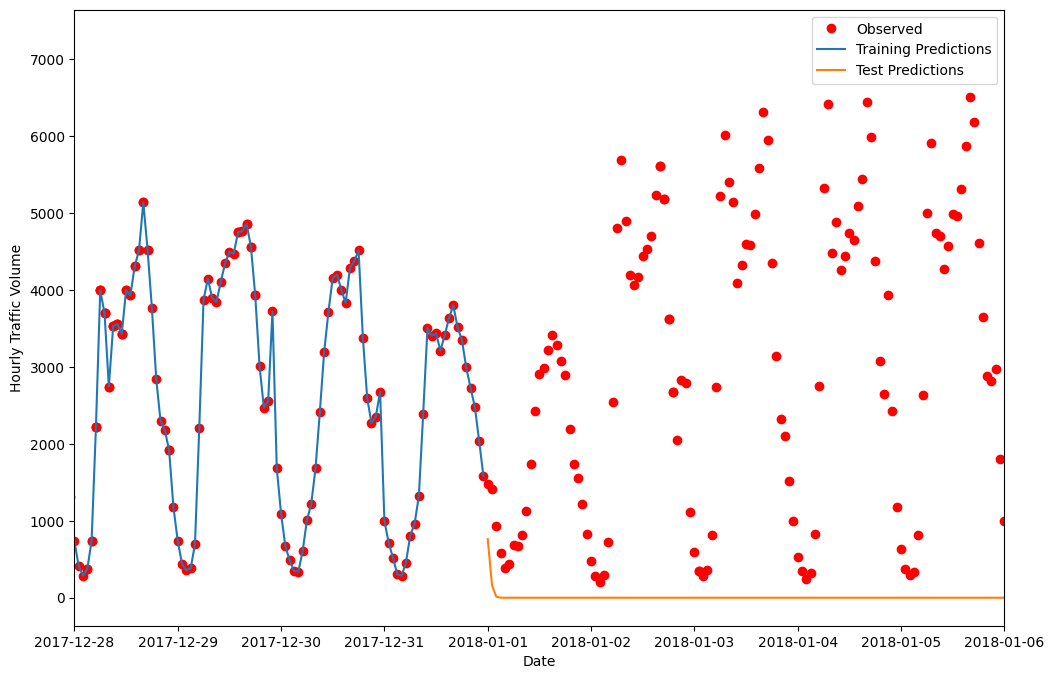

In [45]:
plt.figure(figsize = (12, 8))
plt.plot(df['date_time'], df['traffic_volume'], 'ro', label = 'Observed')
plt.plot(df_train['date_time'], mu_train, label = 'Training Predictions')
plt.plot(df_test['date_time'], mu_test, label = 'Test Predictions')
plt.xlim(dt.datetime(2017, 12, 28, 0), dt.datetime(2018, 1, 6, 0))
plt.xlabel('Date')
plt.ylabel('Hourly Traffic Volume')
plt.legend()
plt.show()

In [50]:
25.533600**2

651.96472896

In [18]:
lst_models = ['RBF', 'Periodic (7 days)', 'Periodic (30 days)', 'Periodic (1 year)', 'Sum Periodic 2', 'Sum Periodic 3']
# rbf: l = 1, (0.000019  3810.599525   0.000014 3259.994986)
# per 7d: l = 0.01 (504.019878   524.063071  17.135188 27.748805) fixed MAE (293.614667, 769.9961789)
# per 30d: l = 0.01 (908.343070	964.969951	24.729560	25.533600) fixed MAE (611.5511379, 651.96472896)
# per 365d: l = 0.01, (971.384057	1308.667891	727.010672	998.101065)
# sum periodic (7d + 365d) : l1 = 0.1, l2 = 10 (483.427173, 529.284352, 293.102737  307.344297)
# 3 periodics (1d, 7d, 365d) l1 = 1.0,l2 = 0.1, l3=10  (483.340359, 529.279920, 292.996449, 307.379825)
x = [0, 1, 2, 3, 4, 5]

lst_train_rmse = [0.000019, 504.019878, 908.343070, 971.384057, 483.427173, 483.340359]
lst_test_rmse = [3810.599525, 524.063071, 964.969951, 1308.667891, 529.284352, 529.279920]

lst_train_mae = [0.000014, 293.614667, 611.5511379, 727.010672, 293.102737, 292.996449]
lst_test_mae= [3259.994986, 769.9961789, 651.96472896, 998.101065, 307.344297, 307.379825]

In [ ]:
df_rmse = pd.DataFrame({
    'Model': lst_models * 2,
    'RMSE': lst_train_rmse + lst_test_rmse,
    'Dataset': ['Train'] * len(lst_models) + ['Validation'] * len(lst_models)
})

df_mae = pd.DataFrame({
    'Model': lst_models * 2,
    'MAE': lst_train_mae + lst_test_mae,
    'Dataset': ['Train'] * len(lst_models) + ['Validation'] * len(lst_models)
})

In [13]:
import seaborn as sns

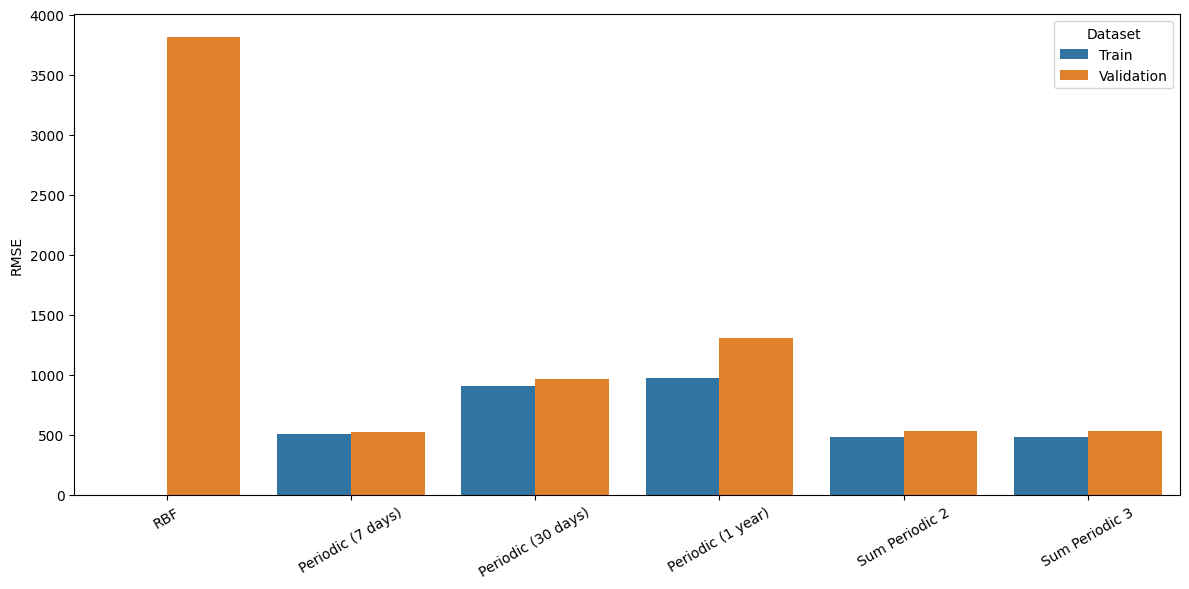

In [21]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df_rmse, x='Model', y='RMSE', hue='Dataset', ax=ax)

# Formatting
ax.set_ylabel('RMSE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

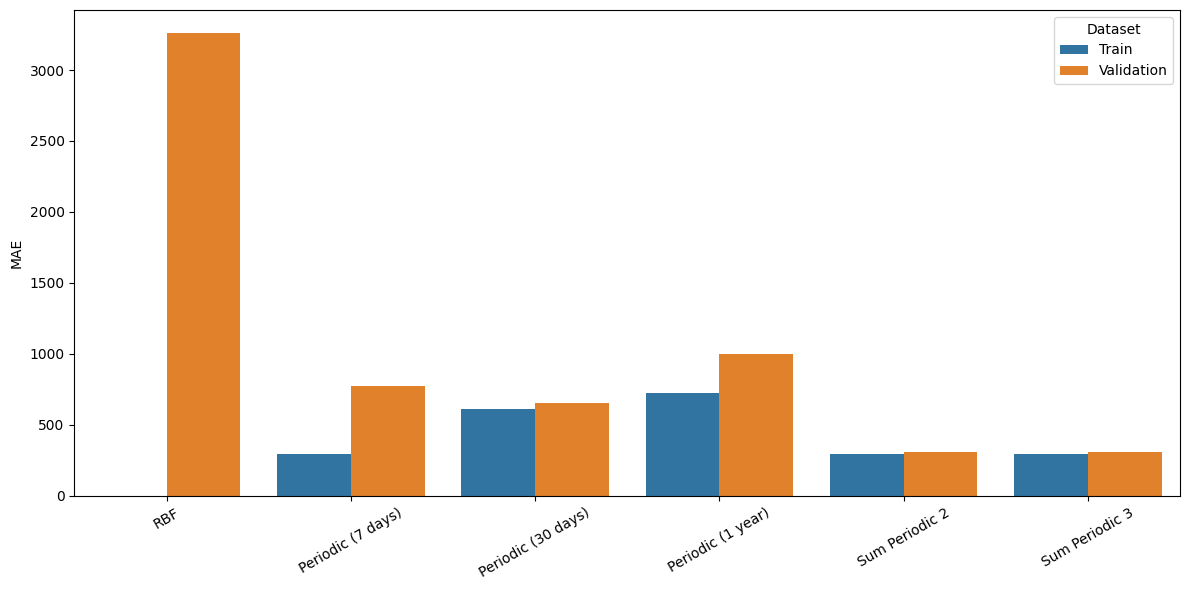

In [25]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df_mae, x='Model', y='MAE', hue='Dataset', ax=ax)

# Formatting
ax.set_ylabel('MAE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

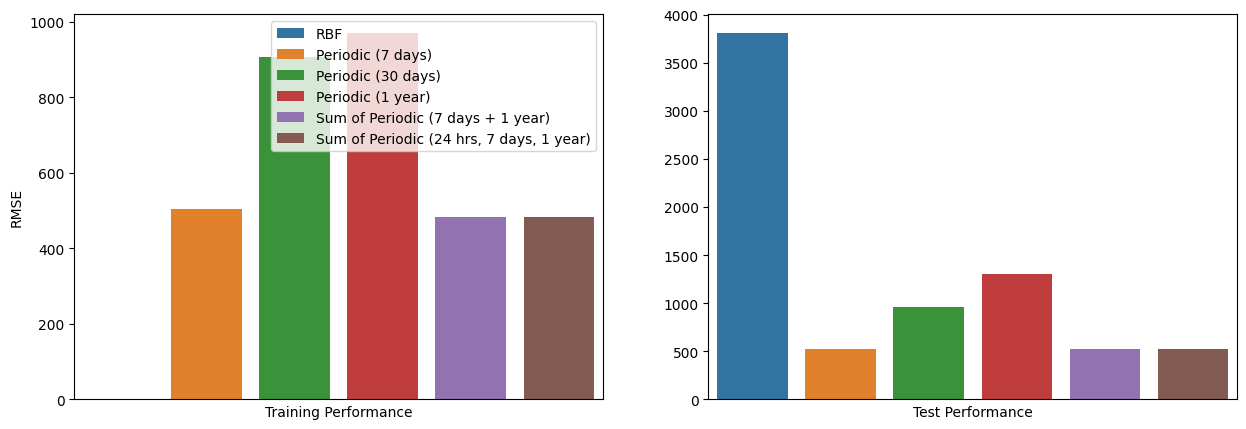

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.barplot(x = x, y = lst_train_rmse, hue = lst_models, ax=ax[0])
sns.barplot(x = lst_models, y = lst_test_rmse, hue = lst_models, ax=ax[1])
ax[0].set_xticklabels('')
ax[0].set_xticks([])
ax[0].set_ylabel('RMSE')
ax[1].set_xticklabels('')
ax[1].set_xticks([])

ax[0].set_xlabel('Training Performance')
ax[1].set_xlabel('Test Performance')


#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')

plt.show()

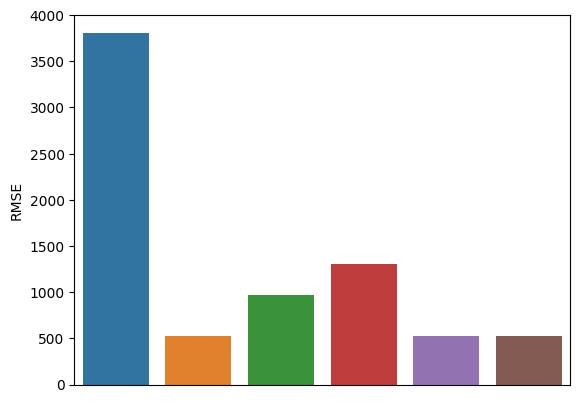

In [73]:
fig, ax = plt.subplots()
sns.barplot(x = lst_models, y = lst_test_rmse, hue = lst_models, ax=ax)
ax.set_xticklabels('')
ax.set_xticks([])
ax.set_ylabel('RMSE')
plt.show()